<a href="https://colab.research.google.com/github/mchirico/COVID-19/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COVID-19**

Note:  You need to make a copy of this note book, if you want to run it yourself
by clicking on "File/Save a copy in Drive"



Sharable link:
https://colab.research.google.com/drive/1RZXskxLFGTMcw7Q88VwIWk7vSceGbIkf







Data From: 
[JHU CSSE](https://github.com/CSSEGISandData/COVID-19)



In [0]:
import requests
import pandas as pd
import numpy as np 
from datetime import datetime



import warnings
warnings.filterwarnings("ignore")

try:
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import pydot
  import libarchive
  import torch
except:
  print("Will try to install software")
  # Lines below .... Only need to be run once at the top of the notebook.
  !pip install -q matplotlib-venn
  # #   https://pypi.python.org/pypi/pydot
  !apt-get -qq install -y graphviz && pip install -q pydot
  !apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
  !pip install -U -q PyDrive
  !pip install --upgrade -q gspread
  
  !pip install torchvision
  
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import pydot
  import libarchive





In [0]:
TMP = '/tmp/data'

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://ihmecovid19storage.blob.core.windows.net/latest/ihme-covid19.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall(TMP)

In [84]:
file = !find  /tmp/data -iname '*.csv'
sdate = file[0][len(TMP)+1: len(TMP)+11]
startDate = datetime.strptime(sdate,'%Y_%m_%d')
startDate

datetime.datetime(2020, 5, 10, 0, 0)

In [85]:
p=pd.read_csv(file[0])
p[p['confirmed_infections'] >= 20].head()


,V1,location_name,date,allbed_mean,allbed_lower,allbed_upper,ICUbed_mean,ICUbed_lower,ICUbed_upper,InvVen_mean,InvVen_lower,InvVen_upper,deaths_mean,deaths_lower,deaths_upper,admis_mean,admis_lower,admis_upper,newICU_mean,newICU_lower,newICU_upper,totdea_mean,totdea_lower,totdea_upper,bedover_mean,bedover_lower,bedover_upper,icuover_mean,icuover_lower,icuover_upper,deaths_mean_smoothed,deaths_lower_smoothed,deaths_upper_smoothed,totdea_mean_smoothed,totdea_lower_smoothed,totdea_upper_smoothed,mobility_data_type,mobility_composite,total_tests_data_type,total_tests,confirmed_infections,est_infections_mean,est_infections_lower,est_infections_upper
86,87,Abruzzo,2020-03-13,29.2308,25.59875,33.90125,8.70435,8.35000,9.15,8.51655,8.20000,8.90,0.0,0.0,0.0,7.33480,5.75000,9.80000,2.23375,2.05,2.50,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,observed,-52.948603,observed,232.285689,20.131392,826.189550,745.971691,972.042365
87,88,Abruzzo,2020-03-14,39.2533,34.90000,44.70375,10.94060,10.50000,11.45,10.69065,10.34875,11.10,0.0,0.0,0.0,11.02250,8.90000,14.05000,3.23625,3.05,3.50,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,observed,-57.046048,observed,240.142831,24.836706,823.524194,729.045519,963.999803
88,89,Abruzzo,2020-03-15,50.4921,45.45000,56.30000,14.40890,13.90000,15.00,14.03620,13.60000,14.55,1.0,1.0,1.0,14.67725,12.10000,18.00000,4.46830,4.15,4.85,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,3.0,3.0,observed,-60.807399,observed,247.999973,30.383177,802.848340,681.599177,938.981127
89,90,Abruzzo,2020-03-16,65.4203,59.15000,71.85000,18.88345,18.29875,19.55,18.38590,17.90000,18.95,1.0,1.0,1.0,18.32120,15.44875,21.75000,5.47455,5.20,5.85,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,4.0,4.0,observed,-64.197910,observed,255.857115,37.072555,768.629183,638.829697,922.787529
90,91,Abruzzo,2020-03-17,83.9820,76.79750,91.50000,24.59685,23.85000,25.45,23.91260,23.30000,24.60,2.0,2.0,2.0,21.99235,18.80000,26.05125,6.71340,6.35,7.20,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,6.0,6.0,6.0,observed,-67.202367,observed,263.714257,44.985402,728.341945,607.858866,880.246094


In [86]:
p2=pd.read_csv(file[1])
#p[p['confirmed_infections'] >= 20].head()
p2.head()


,location_name,peak_bed_day_mean,peak_bed_day_lower,peak_bed_day_upper,peak_icu_bed_day_mean,peak_icu_bed_day_lower,peak_icu_bed_day_upper,peak_vent_day_mean,peak_vent_day_lower,peak_vent_day_upper,all_bed_capacity,icu_bed_capacity,all_bed_usage,icu_bed_usage,available_all_nbr,available_icu_nbr,travel_limit_start_date,travel_limit_end_date,stay_home_start_date,stay_home_end_date,educational_fac_start_date,educational_fac_end_date,any_gathering_restrict_start_date,any_gathering_restrict_end_date,any_business_start_date,any_business_end_date,all_non-ess_business_start_date,all_non-ess_business_end_date
0,Abruzzo,2020-03-30,2020-03-29,2020-03-31,2020-03-30,2020-03-29,2020-03-31,2020-03-30,2020-03-29,2020-03-30,4270.0,153.0,3322.0,112.0,948.0,41.0,2020-03-22,2020-05-04,2020-03-11,NaN,2020-03-05,NaN,2020-03-11,NaN,2020-03-11,NaN,2020-03-11,2020-04-14
1,Alabama,2020-05-10,2020-05-06,2020-05-13,2020-05-09,2020-05-06,2020-05-13,2020-05-09,2020-05-06,2020-05-13,17537.0,1525.0,11793.0,1050.0,5744.0,475.0,NaN,NaN,2020-04-04,2020-04-30,2020-03-19,NaN,2020-03-19,NaN,2020-03-19,NaN,2020-03-28,2020-04-30
2,Alaska,2020-04-02,2020-04-02,2020-04-02,2020-04-04,2020-04-04,2020-04-04,2020-04-04,2020-04-04,2020-04-04,2034.0,169.0,1351.0,115.0,683.0,54.0,2020-03-28,2020-04-24,2020-03-28,2020-04-24,2020-03-16,NaN,2020-03-24,NaN,2020-03-17,NaN,2020-03-28,2020-04-24
3,Alberta,2020-05-04,2020-05-02,2020-06-04,2020-05-04,2020-05-02,2020-06-06,2020-05-04,2020-05-02,2020-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-16,NaN,2020-03-12,NaN,2020-03-18,NaN,NaN,NaN
4,Amazonas,2020-05-22,2020-05-06,2020-05-29,2020-05-23,2020-05-08,2020-05-31,2020-05-22,2020-05-08,2020-05-29,4747.0,276.0,3721.0,236.0,1026.0,40.0,NaN,NaN,NaN,NaN,2020-03-16,NaN,2020-03-31,NaN,2020-03-19,NaN,2020-03-24,NaN


## Reading in the data..

#### Read in Confirmed Cases

In [87]:
# 
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
d=pd.read_csv(url)
d.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,121,128,130,133,133,133,133,135,135,136,136,136,136,136,136,139,141,141,141,141,141,141,145,145,145,145,145,145,149,149,151,151,151,151,152,152,152,154,154,154
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11,11,11,11,11,11,11,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,15,15,15,16,16,19,19,19,19,19,21,21
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,620,683,725,788,897,903,923,974,1043,1068,1118,1213,1252,1298,1252,1416,1276,1307,1371,1389,1400,1433,1539,1575,1757,1808,1843,1924,1968,2031,2156,2173,2198,2256,2299,2329,2427,2542,2589,2646
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,45,45,50,51,51,51,51,51,51,51,53,53,53,53,54,54,54,55,57,57,57,57,66,66,66,66,66,66,66,66,68,68,69,69,69,69,69,69,69,69


In [88]:
PERIODS = 7

c=d
cols = d.columns[10:11].tolist() + d.columns[11::].tolist()
cols
c=c[cols]
c=c.set_index('Combined_Key')
x=c.diff(axis=1,periods=PERIODS)
x=x.reset_index()
c=c.diff(axis=1)

c=c.reset_index()
c

,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
0,"American Samoa, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Guam, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,2.0,3.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0
2,"Northern Mariana Islands, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0
3,"Puerto Rico, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,47.0,63.0,42.0,63.0,109.0,6.0,20.0,51.0,69.0,25.0,50.0,95.0,39.0,46.0,-46.0,164.0,-140.0,31.0,64.0,18.0,11.0,33.0,106.0,36.0,182.0,51.0,35.0,81.0,44.0,63.0,125.0,17.0,25.0,58.0,43.0,30.0,98.0,115.0,47.0,57.0
4,"Virgin Islands, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256,"Central Utah, Utah, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3257,"Southeast Utah, Utah, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,1.0,-2.0,1.0,2.0,-4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,1.0,0.0
3258,"Southwest Utah, Utah, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,4.0,0.0,0.0,6.0,5.0,2.0,4.0,2.0,2.0,2.0,5.0,3.0,2.0,8.0,8.0,2.0,7.0,4.0,6.0,17.0,9.0,6.0,-3.0,13.0,7.0,13.0,9.0,10.0
3259,"TriCounty, Utah, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [89]:
x.head()

,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
0,"American Samoa, US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Guam, US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.0,46.0,46.0,40.0,21.0,20.0,12.0,14.0,7.0,6.0,3.0,3.0,3.0,3.0,1.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,4.0,4.0,4.0,4.0,4.0,8.0,4.0,6.0,6.0,6.0,6.0,7.0,3.0,3.0,3.0,3.0,3.0
2,"Northern Mariana Islands, US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0
3,"Puerto Rico, US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,334.0,367.0,409.0,336.0,422.0,390.0,350.0,354.0,360.0,343.0,330.0,316.0,349.0,375.0,278.0,373.0,208.0,189.0,158.0,137.0,102.0,181.0,123.0,299.0,450.0,437.0,454.0,524.0,535.0,492.0,581.0,416.0,390.0,413.0,375.0,361.0,396.0,386.0,416.0,448.0
4,"Virgin Islands, US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,15.0,13.0,11.0,9.0,8.0,8.0,6.0,6.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,2.0,4.0,4.0,4.0,3.0,12.0,12.0,11.0,9.0,9.0,9.0,9.0,0.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,0.0


In [90]:
n=pd.melt(x, id_vars=['Combined_Key'], value_vars=x.columns[2::])
n.columns = ['Country/Region', 'timeStamp',  'value']
n['timeStamp'] = n['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
n.head()

,Country/Region,timeStamp,value
0,"American Samoa, US",2020-01-23,NaN
1,"Guam, US",2020-01-23,NaN
2,"Northern Mariana Islands, US",2020-01-23,NaN
3,"Puerto Rico, US",2020-01-23,NaN
4,"Virgin Islands, US",2020-01-23,NaN


## N is smoother

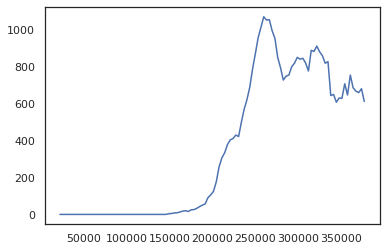

In [91]:

regions = ['Montgomery, Pennsylvania, US']
for region in regions:
  z= n[n['Country/Region'].str.find(region,0)==0]
  z['value'].plot.line(x='timeStamp',y='value');

In [92]:
m=pd.melt(c, id_vars=['Combined_Key'], value_vars=c.columns[2::])
m.columns = ['Country/Region', 'timeStamp',  'value']
m['timeStamp'] = m['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
m.head()

,Country/Region,timeStamp,value
0,"American Samoa, US",2020-01-23,0.0
1,"Guam, US",2020-01-23,0.0
2,"Northern Mariana Islands, US",2020-01-23,0.0
3,"Puerto Rico, US",2020-01-23,0.0
4,"Virgin Islands, US",2020-01-23,0.0


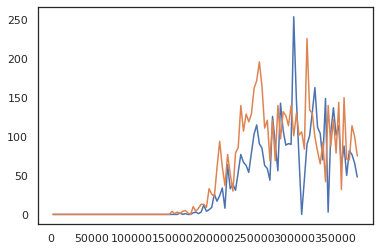

In [93]:
regions = ['Bucks, Pennsylvania, US','Montgomery, Pennsylvania, US']
for region in regions:
  z= m[m['Country/Region'].str.find(region,0)==0]
  z['value'].plot.line();

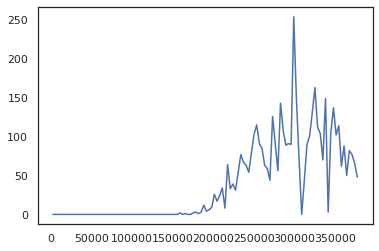

In [94]:
regions = ['Bucks, Pennsylvania, US']
for region in regions:
  m[m['Country/Region'].str.find(region,0)==0]['value'].plot.line();

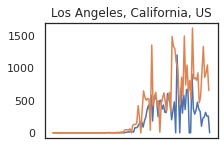

In [95]:
regions = ['Philadelphia, Pennsylvania, US']
regions = ['Potter, Texas, US']
regions = ['Dallas, Texas, US']
#regions = ['New York City, New York, US']
regions = ['Los Angeles, California, US']
regions = ['Philadelphia, Pennsylvania, US','Los Angeles, California, US']
fig=plt.figure()
for region in regions:
  m[m['Country/Region'].str.find(region,0)==0]['value'].plot.line(title=region,xticks=[],ax=fig.add_axes((0.05,0.5,0.4,0.4)));
plt.show()

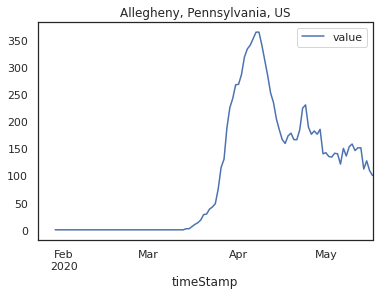

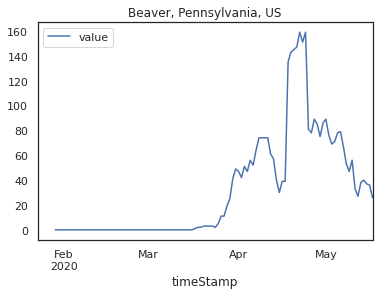

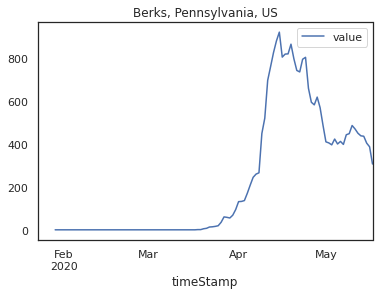

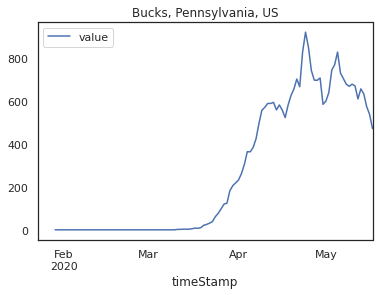

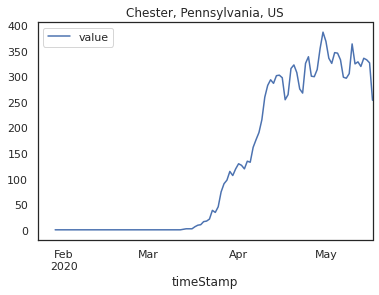

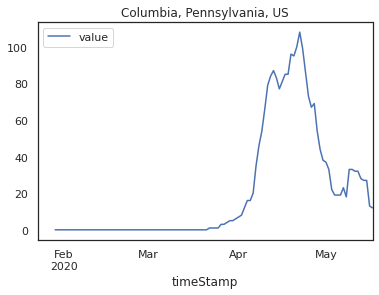

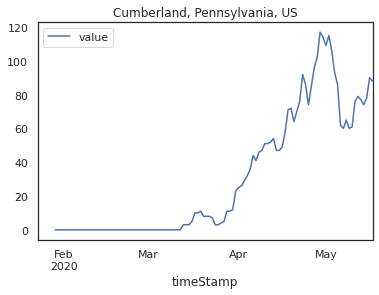

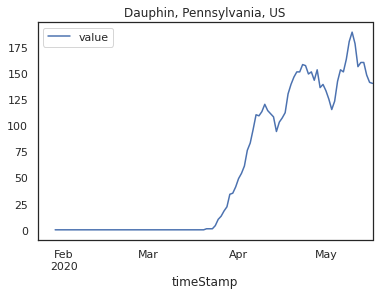

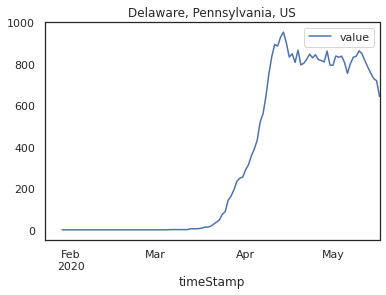

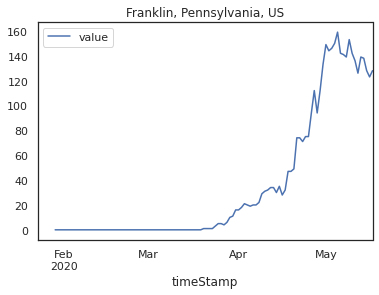

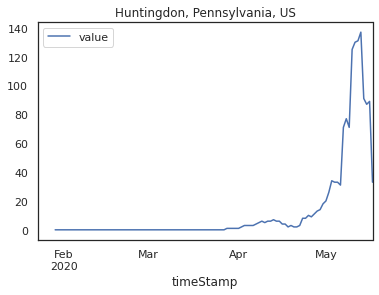

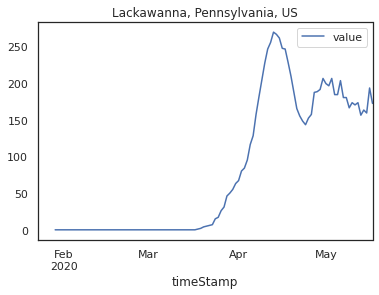

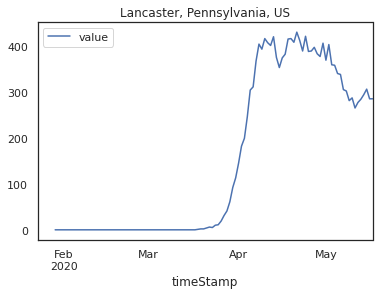

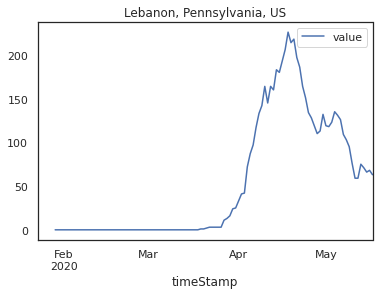

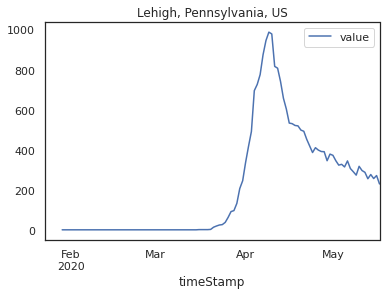

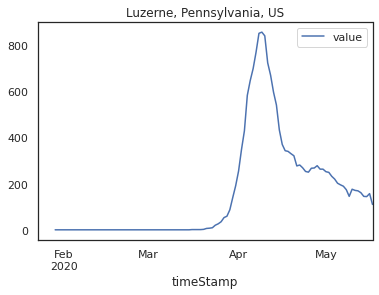

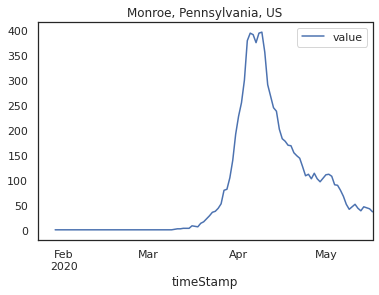

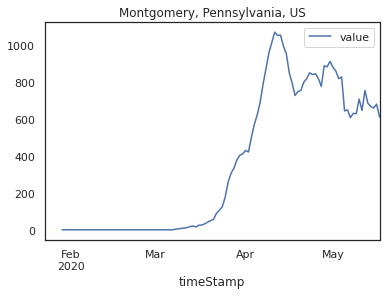

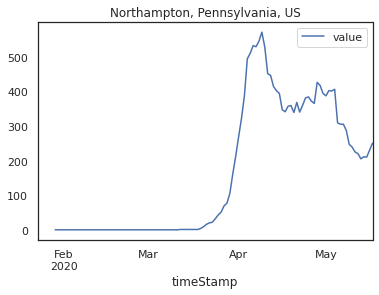

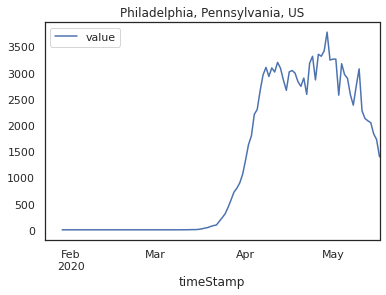

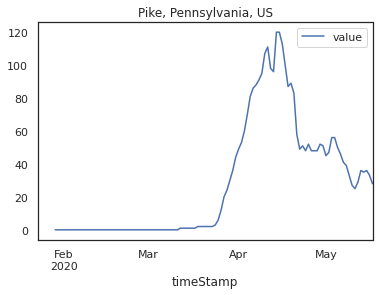

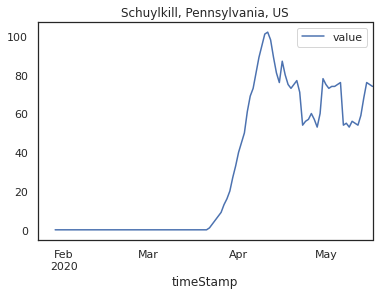

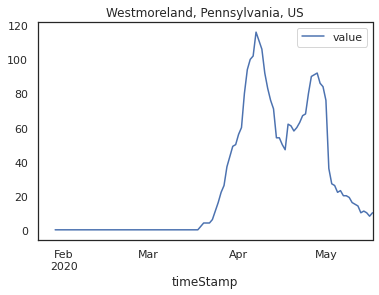

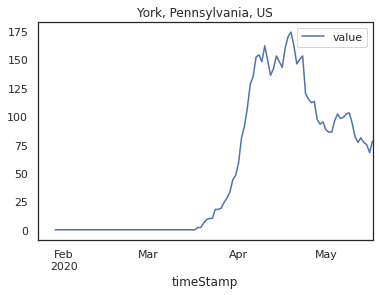

In [96]:
import matplotlib.pyplot as plt


t = n[(n['Country/Region'].str.find('Pennsylvania',0)!= -1)]
my_list = t[t['value']>100]['Country/Region'].unique()
t=t[t['Country/Region'].isin(my_list)]

for title, group in t.groupby('Country/Region'):
    group.plot(x='timeStamp', y='value', title=title)

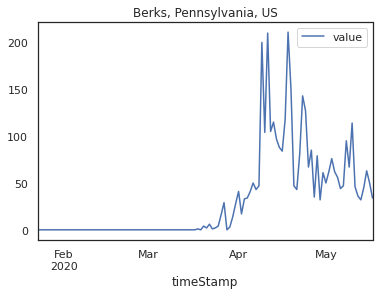

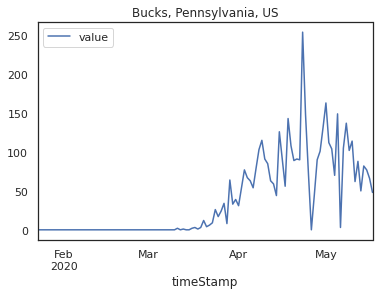

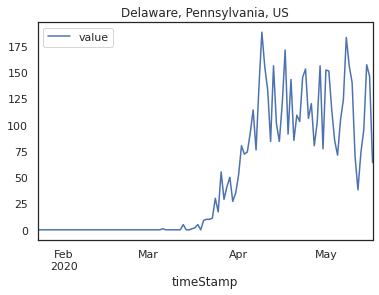

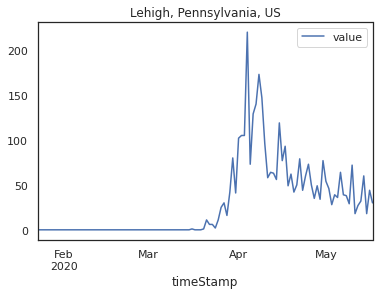

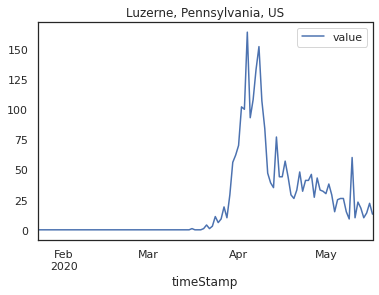

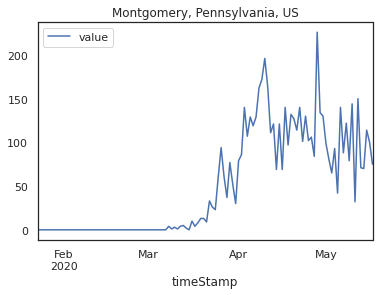

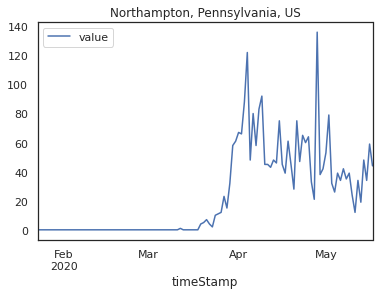

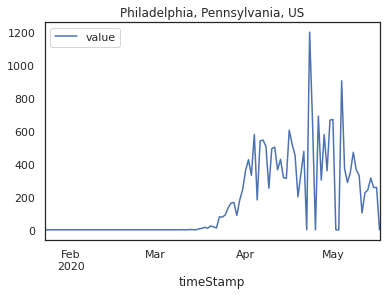

In [97]:
import matplotlib.pyplot as plt


t = m[(m['Country/Region'].str.find('Pennsylvania',0)!= -1)]
my_list = t[t['value']>100]['Country/Region'].unique()
t=t[t['Country/Region'].isin(my_list)]

for title, group in t.groupby('Country/Region'):
    group.plot(x='timeStamp', y='value', title=title)

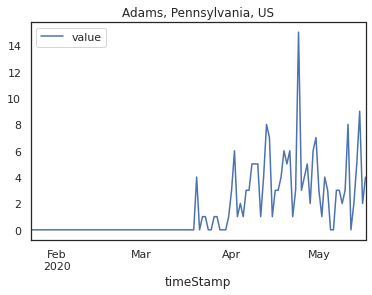

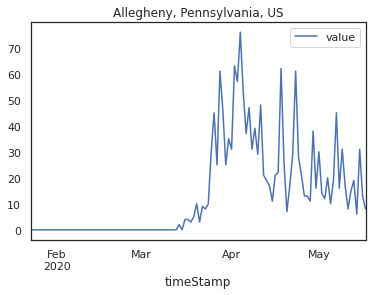

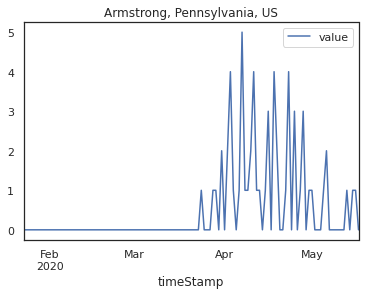

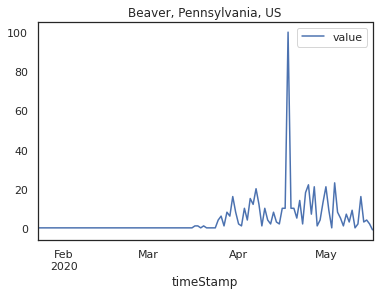

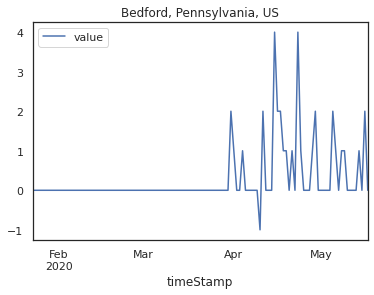

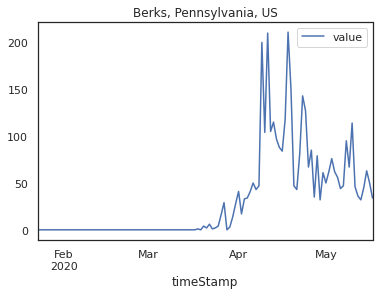

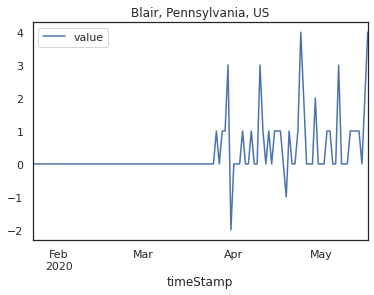

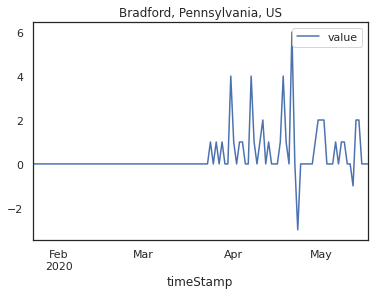

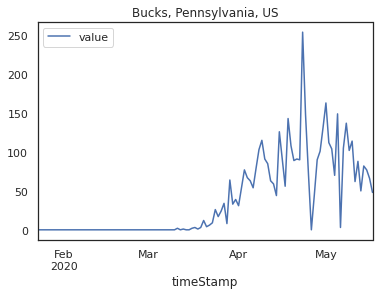

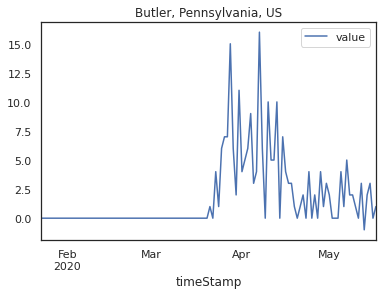

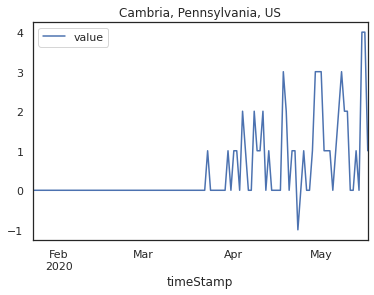

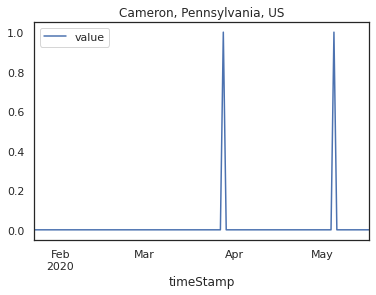

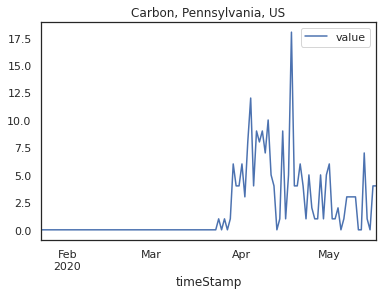

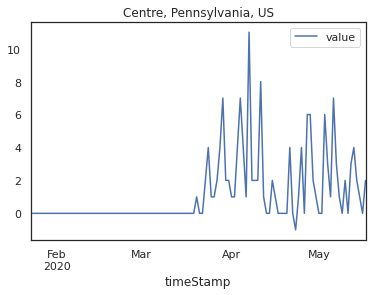

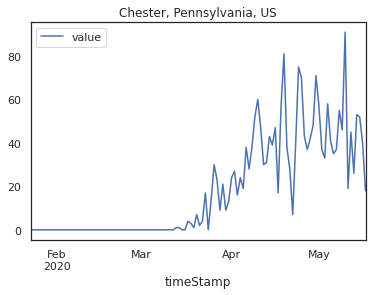

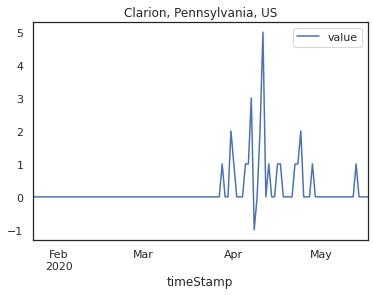

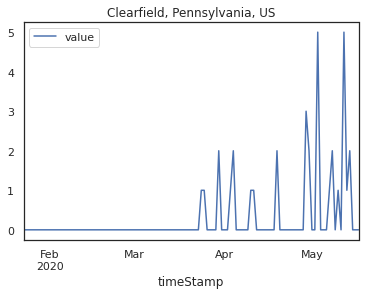

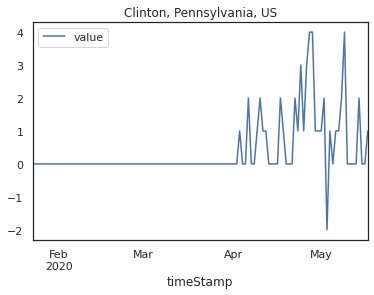

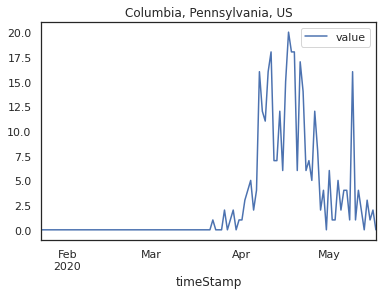

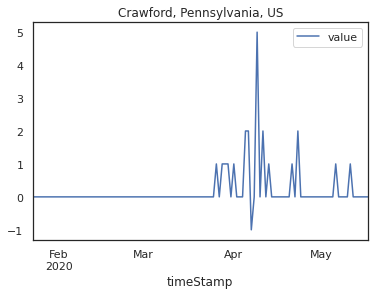

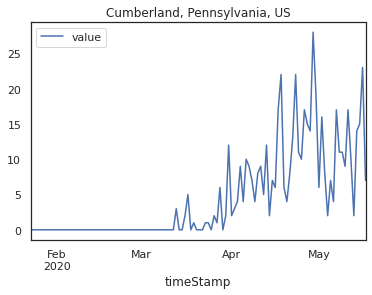

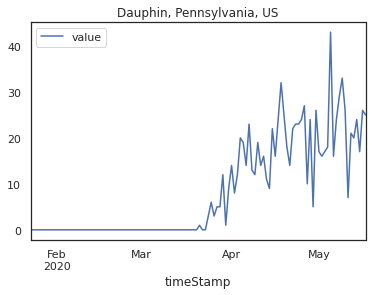

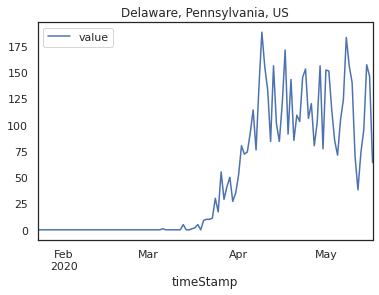

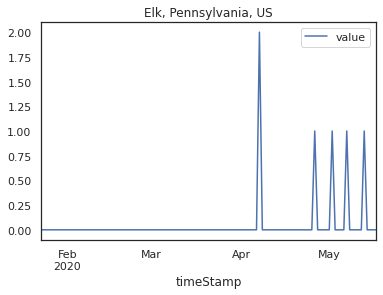

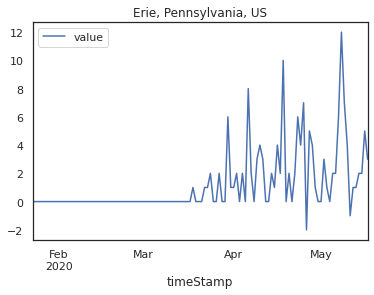

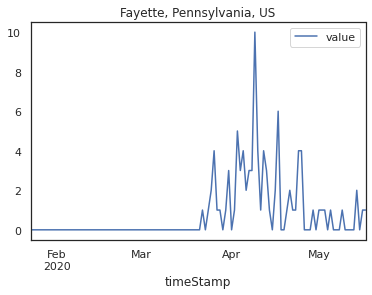

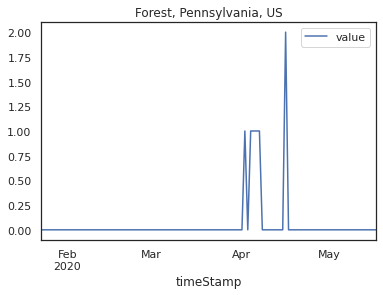

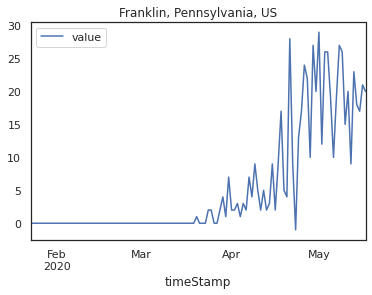

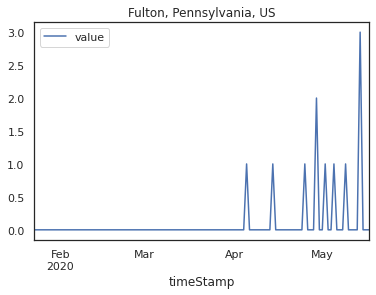

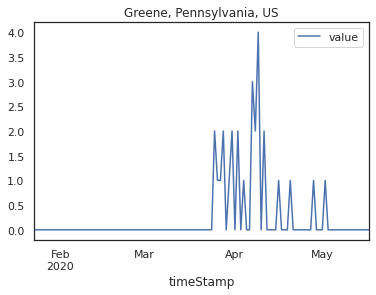

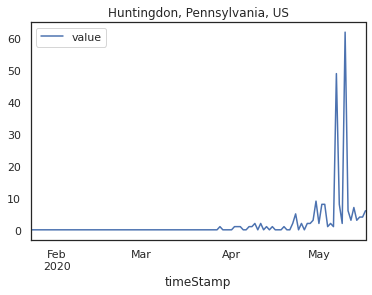

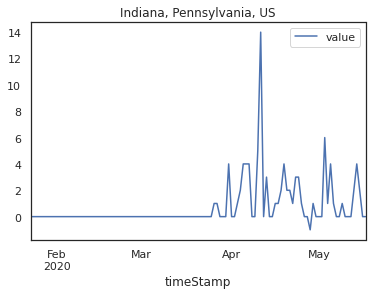

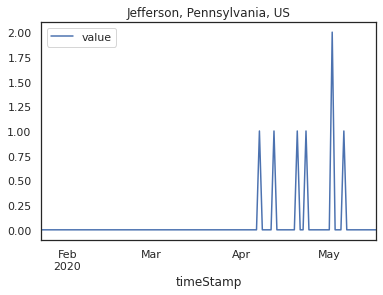

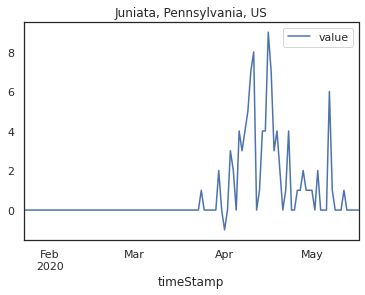

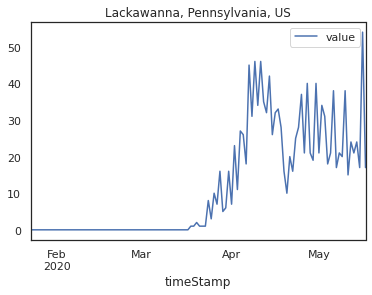

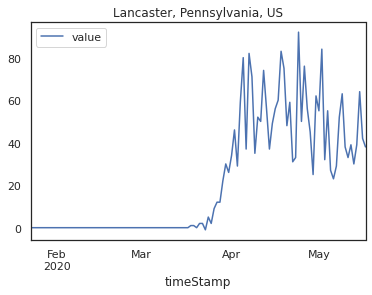

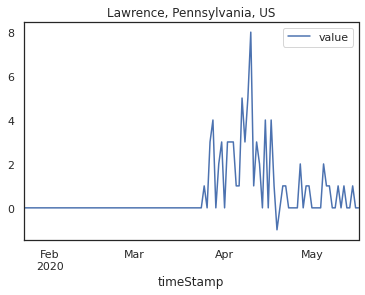

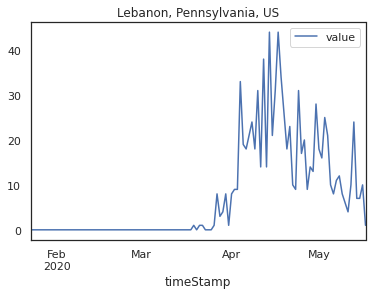

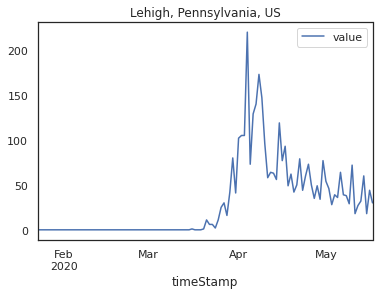

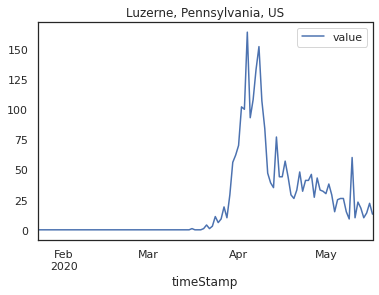

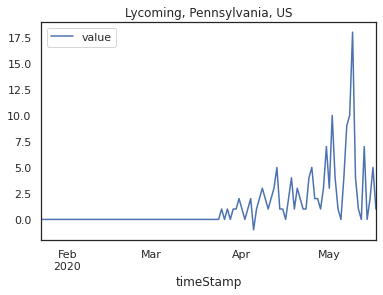

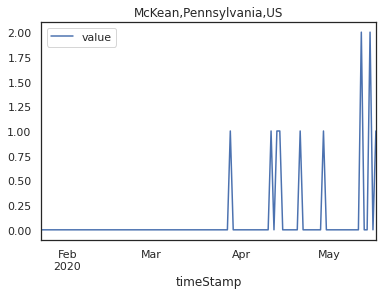

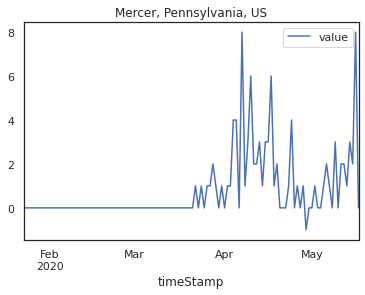

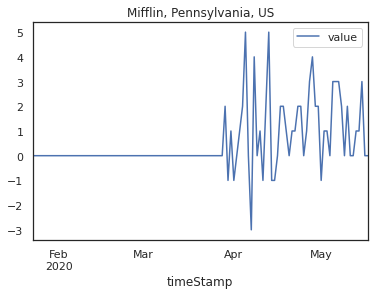

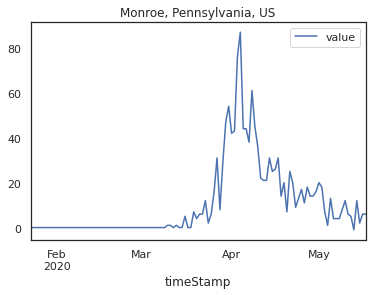

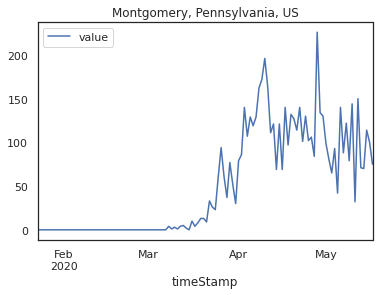

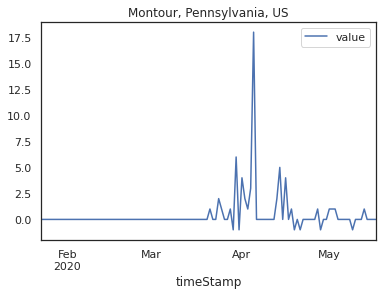

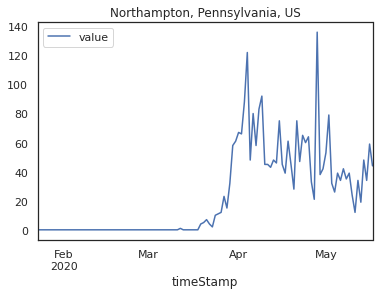

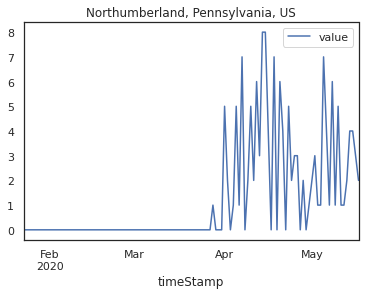

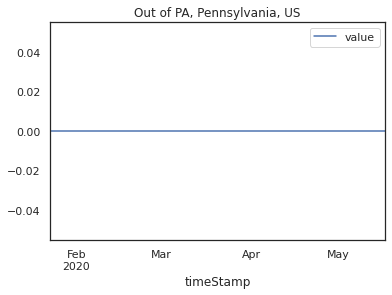

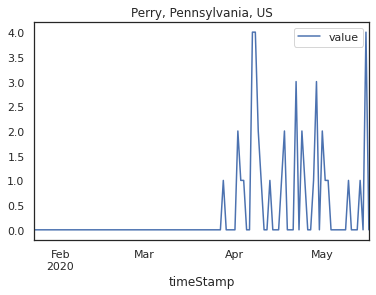

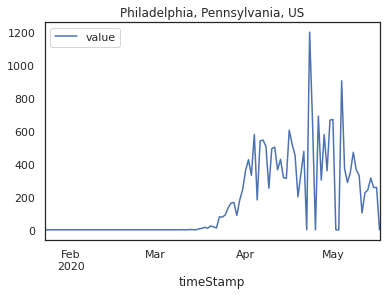

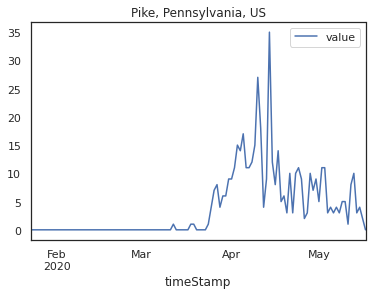

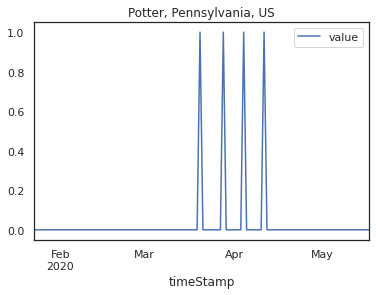

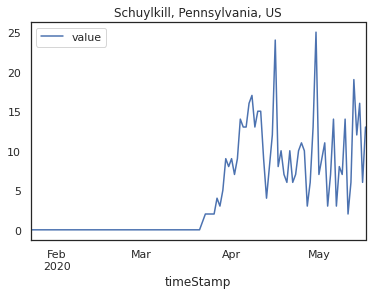

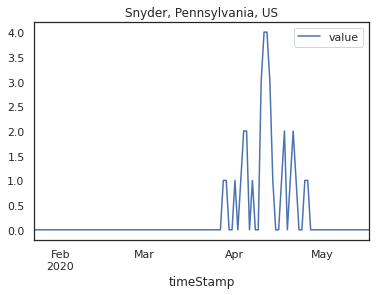

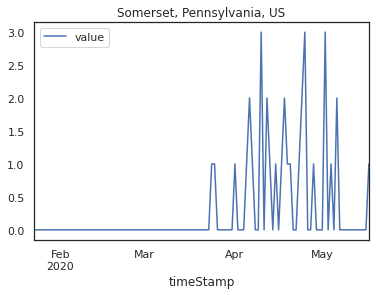

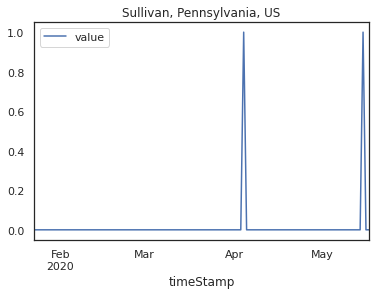

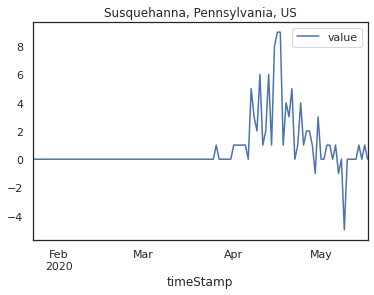

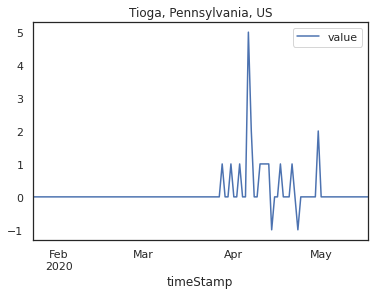

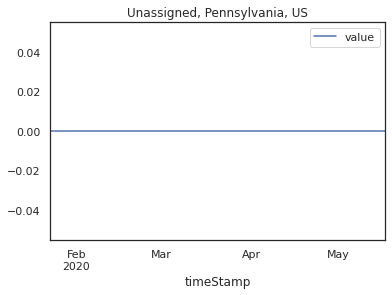

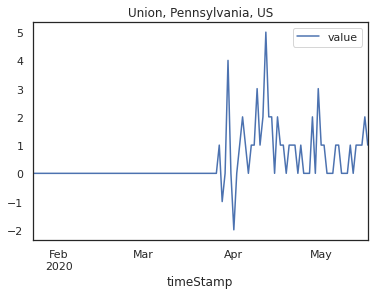

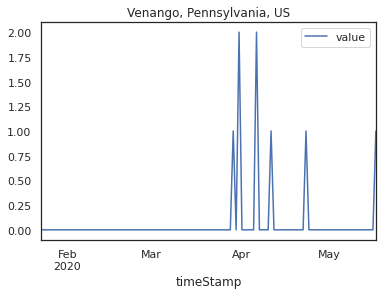

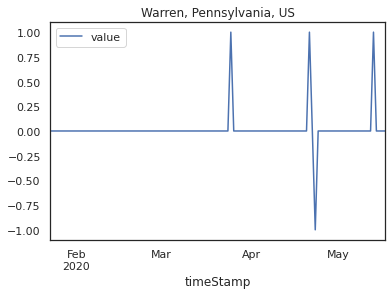

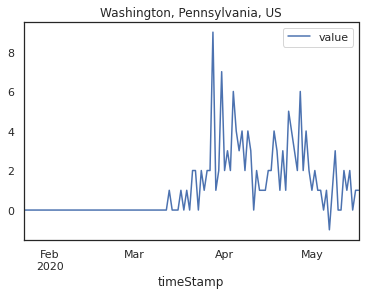

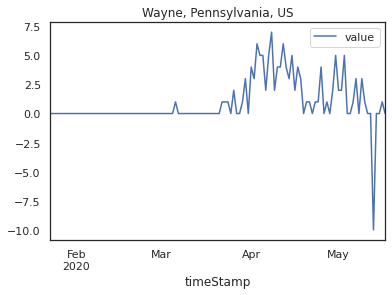

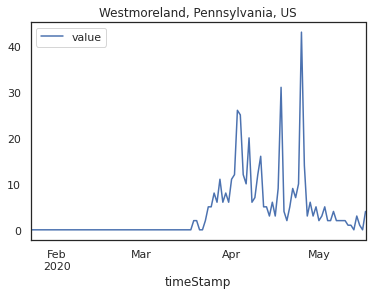

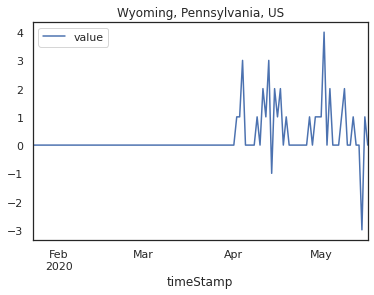

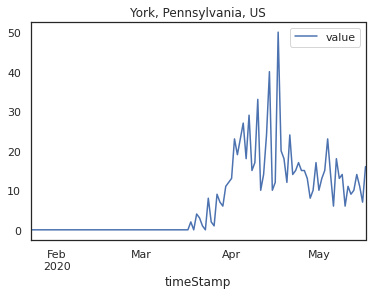

In [98]:
import matplotlib.pyplot as plt
t = m[(m['Country/Region'].str.find('Pennsylvania',0)!= -1)]
for title, group in t.groupby('Country/Region'):
    group.plot(x='timeStamp', y='value', title=title)

In [99]:
delta_days = 20

from datetime import date, timedelta
dt = date.today() - timedelta(delta_days)
dt.strftime("%Y-%m-%d")

'2020-04-28'

In [100]:
penn = m[m['Country/Region'].str.contains('Pennsylvania', regex=False)]
penn = m
penn = penn[penn['timeStamp'] >= dt.strftime("%Y-%m-%d") ]
penn['timeStamp'].describe()

count                   65220
unique                     20
top       2020-05-05 00:00:00
freq                     3261
first     2020-04-28 00:00:00
last      2020-05-17 00:00:00
Name: timeStamp, dtype: object

In [0]:

pp = penn.pivot(index='Country/Region', columns='timeStamp', values='value')
#sns.heatmap(pp, annot=True)

In [102]:
pp.diff(axis=1)

timeStamp,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17
Country/Region,,,,,,,,,,,,,,,,,,,,
"Abbeville, South Carolina, US",NaN,0.0,2.0,-2.0,0.0,2.0,-2.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Acadia, Louisiana, US",NaN,0.0,0.0,3.0,-3.0,1.0,-1.0,2.0,2.0,-2.0,-2.0,9.0,-12.0,7.0,-4.0,-1.0,9.0,22.0,-27.0,3.0
"Accomack, Virginia, US",NaN,-22.0,29.0,4.0,11.0,-3.0,-22.0,-21.0,0.0,26.0,-30.0,33.0,-21.0,4.0,-10.0,9.0,33.0,7.0,-35.0,0.0
"Ada, Idaho, US",NaN,-12.0,9.0,1.0,14.0,-24.0,5.0,-2.0,1.0,0.0,-4.0,10.0,-8.0,4.0,-1.0,-5.0,15.0,-15.0,14.0,-14.0
"Adair, Iowa, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Yuma, Arizona, US",NaN,0.0,8.0,-9.0,-4.0,9.0,8.0,-17.0,19.0,-5.0,-3.0,6.0,-2.0,-7.0,0.0,68.0,-74.0,23.0,28.0,-53.0
"Yuma, Colorado, US",NaN,0.0,-1.0,1.0,-2.0,2.0,-1.0,0.0,0.0,1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0,1.0,-1.0,0.0
"Zapata, Texas, US",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
t = pp.diff(axis=1).reset_index()
md=pd.melt(t, id_vars=['Country/Region'], value_vars=t.columns[2::])

md.head()

,Country/Region,timeStamp,value
0,"Abbeville, South Carolina, US",2020-04-29,0.0
1,"Acadia, Louisiana, US",2020-04-29,0.0
2,"Accomack, Virginia, US",2020-04-29,-22.0
3,"Ada, Idaho, US",2020-04-29,-12.0
4,"Adair, Iowa, US",2020-04-29,0.0


In [104]:
r = md.groupby(['Country/Region', pd.Grouper(key='timeStamp', freq='5d')]).describe()
r = r.reset_index()
r.columns = r.columns.get_level_values(0)
new_index = ['Country/Region', 'timeStamp', 'count',	'mean',	'std',	'min',	'25%',	'50%',	'75%',	'max']
r.columns = new_index

r[r['max'] > 100]

,Country/Region,timeStamp,count,mean,std,min,25%,50%,75%,max
493,"Baltimore City, Maryland, US",2020-05-04,5.0,0.60,63.720483,-55.0,-39.00,-19.0,10.00,106.0
494,"Baltimore City, Maryland, US",2020-05-09,5.0,-2.60,126.539717,-158.0,-73.00,15.0,21.00,182.0
497,"Baltimore, Maryland, US",2020-05-04,5.0,-3.40,104.681899,-165.0,-34.00,29.0,38.00,115.0
498,"Baltimore, Maryland, US",2020-05-09,5.0,1.60,100.949492,-127.0,-39.00,6.0,17.00,151.0
771,"Bergen, New Jersey, US",2020-05-14,4.0,14.00,139.372403,-129.0,-80.25,0.0,94.25,185.0
808,"Bexar, Texas, US",2020-04-29,5.0,33.40,69.013042,-67.0,5.00,35.0,91.00,103.0
811,"Bexar, Texas, US",2020-05-14,4.0,-10.25,118.682700,-144.0,-61.50,-20.5,30.75,144.0
1140,"Broward, Florida, US",2020-04-29,5.0,0.40,83.611004,-78.0,-58.00,-2.0,4.00,136.0
1217,"Bucks, Pennsylvania, US",2020-05-04,5.0,6.60,99.903954,-146.0,-34.00,32.0,79.00,102.0
1281,"Burlington, New Jersey, US",2020-05-04,5.0,-20.00,91.692421,-107.0,-79.00,-68.0,50.00,104.0


In [105]:
r[r['Country/Region']=='Montgomery, Pennsylvania, US']

,Country/Region,timeStamp,count,mean,std,min,25%,50%,75%,max
7992,"Montgomery, Pennsylvania, US",2020-04-29,5.0,-32.2,34.773553,-92.0,-31.00,-18.0,-16.00,-4.0
7993,"Montgomery, Pennsylvania, US",2020-05-04,5.0,11.4,63.638039,-52.0,-51.00,28.0,34.00,98.0
7994,"Montgomery, Pennsylvania, US",2020-05-09,5.0,-10.2,97.804397,-112.0,-79.00,-43.0,65.00,118.0
7995,"Montgomery, Pennsylvania, US",2020-05-14,4.0,1.0,30.298515,-25.0,-16.75,-7.5,10.25,44.0


In [106]:
r.head()

,Country/Region,timeStamp,count,mean,std,min,25%,50%,75%,max
0,"Abbeville, South Carolina, US",2020-04-29,5.0,0.40,1.673320,-2.0,0.0,0.0,2.00,2.0
1,"Abbeville, South Carolina, US",2020-05-04,5.0,-0.40,1.140175,-2.0,-1.0,0.0,0.00,1.0
2,"Abbeville, South Carolina, US",2020-05-09,5.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0
3,"Abbeville, South Carolina, US",2020-05-14,4.0,0.25,0.500000,0.0,0.0,0.0,0.25,1.0
4,"Acadia, Louisiana, US",2020-04-29,5.0,0.20,2.167948,-3.0,0.0,0.0,1.00,3.0


In [107]:
t=md.groupby(['Country/Region', pd.Grouper(key='timeStamp', freq='3d')]).sum()
t=t.reset_index()
total = t.groupby(['Country/Region']).sum().reset_index()
total[total['Country/Region']=='Montgomery, Pennsylvania, US']

,Country/Region,value
1998,"Montgomery, Pennsylvania, US",-151.0


In [108]:
pd.set_option('display.max_rows', 1000)
ts = total.sort_values('value',ascending=False)
ts[ts['value']>100].head(300)

,Country/Region,value
1229,"Hartford, Connecticut, US",357.0
1920,"Michigan Department of Corrections (MDOC), Mic...",285.0
2925,"Unassigned, Georgia, US",273.0
2936,"Unassigned, Massachusetts, US",176.0
1217,"Harris, Texas, US",140.0
1936,"Milwaukee, Wisconsin, US",138.0
2954,"Unassigned, Rhode Island, US",133.0
2150,"Orange, California, US",129.0
1408,"Jefferson, Arkansas, US",127.0
1251,"Hennepin, Minnesota, US",120.0


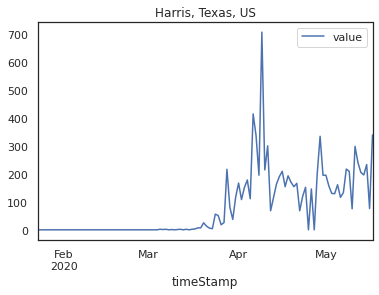

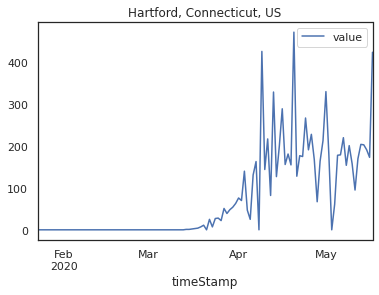

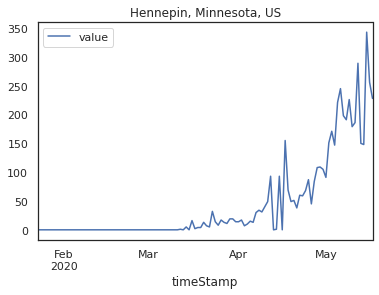

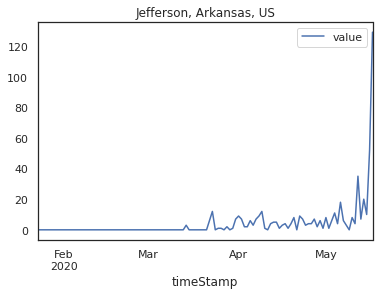

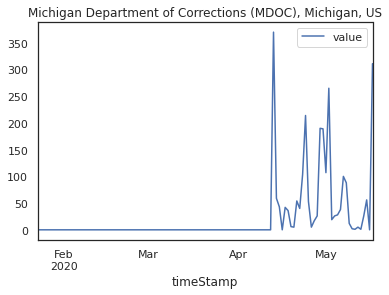

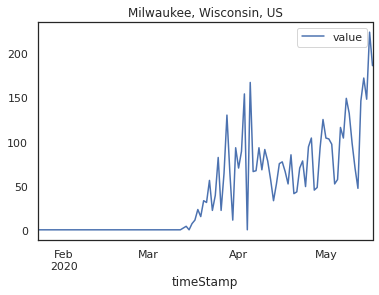

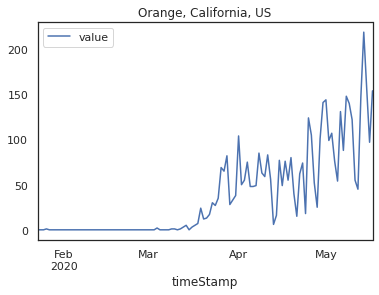

In [110]:

my_list = ts[ts['value']>100]['Country/Region'].tolist()[0:300]
bad_data = m[m['value']<0]['Country/Region'].unique().tolist()

t=m[m['Country/Region'].isin(my_list)]
t = t[~t['Country/Region'].isin(bad_data)]




t=m[m['Country/Region'].isin(my_list)]
t=t[~t['Country/Region'].isin(bad_data)]

for title, group in t.groupby('Country/Region'):
    group.plot(x='timeStamp', y='value', title=title)